# Predicción de temperatura utilizando Transformers

## Pablo Monzón Terrazas | A01562619

Durante esta actividad se trabajará con el conjunto de datos de series temporales meteorológicas recopilados en la estación meteorológica del Instituto Max Planck de Biogeoquímica en Jena, Alemania.

Se dará un enfoque en los datos desde 2009 hasta 2016 de temperatura. Nuestro objetivo es construir un modelo que utilice datos históricos recientes (correspondientes a unos pocos días) como entrada y prediga la temperatura del aire con 24 horas de anticipación.

A continuación se da el paso de obtener y descomprimir los datos:

In [1]:
%%bash
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

--2025-04-22 23:54:30--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.51.72, 16.15.176.169, 16.182.32.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.51.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

     0K .......... .......... .......... .......... ..........  0%  884K 15s
    50K .......... .......... .......... .......... ..........  0%  890K 15s
   100K .......... .......... .......... .......... ..........  1%  132M 10s
   150K .......... .......... .......... .......... ..........  1%  888K 11s
   200K .......... .......... .......... .......... ..........  1% 64.4M 9s
   250K .......... .......... .......... .......... ..........  2%  124M 7s
   300K .......... .......... .......... .......... ..........  2%  150M 6s
   350K .......... .......... .......... .......... ....

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Se importan las librerías necesarias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2025-04-23 02:34:49.789895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 02:34:49.797573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 02:34:49.813537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745375689.841212    3790 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745375689.848750    3790 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745375689.872865    3790 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

A continuación se abre el archivo tipo `csv`, se almacenan los datos en la variable data, y se imprime el nombre de las variables así como la cantidad de datos. 

In [2]:
data_dir = '/workspaces/PrediccionTransformers/jena_climate'
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Se esta trabajando con 14 variables y con 420,451 registros. A continuación, se crearán dos arreglos de tipo `NumPy`:uno para la variable de temperatura (`temperature`), y el otro para los demás datos (`raw_data`).  

In [3]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Se hace una visualización de la temperatura a través del tiempo, donde claramente se puede ver una periodicidad en los datos.

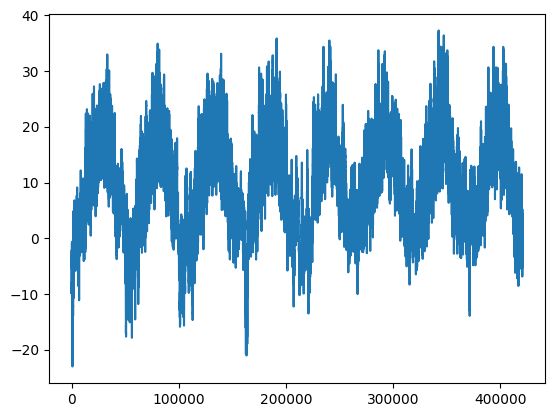

In [4]:
plt.plot(range(len(temperature)), temperature)

## Preparación de los datos

Como primer paso se hace la normalización de los datos para que no exista un problema en la escala de las unidades de la temperatura

In [5]:
mean = raw_data[: 200000].mean(axis=0)
raw_data -= mean
std = raw_data[: 200000].std(axis=0)
raw_data /= std

## Ventanas de tiempo

A continuación se crean las ventanas de tiempo donde se mira al pasado 24 horas antes, así como una predicción de las siguientes 24 horas tomando una hora entre muestras.

In [6]:
past = 144        # 24h de historial
delay = 144       # predecir 24h adelante
step = 6          # 1 hora entre muestras

def create_sequences(data, target, past, delay, step):
    xs, ys = [], []
    for i in range(past, len(data) - delay):
        x = data[i - past:i:step]
        y = target[i + delay]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x, y = create_sequences(raw_data, temperature, past, delay, step)

## Entrenamiento y prueba
A continuación se hace una división de los datos en entrenamiento y prueba con una proporción de 80-20

In [7]:
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

Se hace la permutación sugerida en el ejemplo de Keras para transformers

In [8]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Se realiza la creación del modelo transformer para tener una salida tipo regresión

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(input_shape, head_size=128, num_heads=4, ff_dim=128, num_blocks=2, mlp_units=[64], dropout=0.1, mlp_dropout=0.3):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = layers.GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x) 
    return keras.Model(inputs, outputs)

Se realiza el entrenamiento, así como la evaluación del modelo construido

In [11]:
input_shape = x_train.shape[1:]
model = build_model(input_shape)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"]
)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

loss, mae = model.evaluate(x_test, y_test)
print(f"Test MAE: {mae:.2f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 14)    │     30,222 │ input_layer_1[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 14)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 14)    │         28 │ dropout_8[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 24, 128)   │      1,920 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 24, 128)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 24, 14)    │      1,806 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 14)    │         28 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 24, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 14)    │     30,222 │ add_5[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 24, 14)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 14)    │         28 │ dropout_11[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 24, 14)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 24, 128)   │      1,920 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 24, 128)   │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 24, 14)    │      1,806 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 14)    │         28 │ conv1d_7[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 24, 14)    │          0 │ layer_normalizat

 Total params: 69,033 (269.66 KB)

 Trainable params: 69,033 (269.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-04-23 02:35:44.239941: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 361406976 exceeds 10% of free system memory.


4201/4202 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 29.3624 - mae: 4.0701

2025-04-23 02:38:18.128999: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90351744 exceeds 10% of free system memory.


4202/4202 ━━━━━━━━━━━━━━━━━━━━ 167s 39ms/step - loss: 29.3588 - mae: 4.0698 - val_loss: 16.7247 - val_mae: 3.2190
Epoch 2/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 161s 38ms/step - loss: 18.3177 - mae: 3.3584 - val_loss: 15.7864 - val_mae: 3.1642
Epoch 3/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 162s 38ms/step - loss: 17.2884 - mae: 3.2590 - val_loss: 14.6108 - val_mae: 3.0121
Epoch 4/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 162s 39ms/step - loss: 16.5607 - mae: 3.1829 - val_loss: 14.2301 - val_mae: 2.9867
Epoch 5/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 162s 39ms/step - loss: 15.8586 - mae: 3.1092 - val_loss: 13.1741 - val_mae: 2.8531
Epoch 6/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 161s 38ms/step - loss: 15.1885 - mae: 3.0442 - val_loss: 12.7741 - val_mae: 2.8211
Epoch 7/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 162s 38ms/step - loss: 14.6345 - mae: 2.9840 - val_loss: 12.8978 - val_mae: 2.8246
Epoch 8/20
4202/4202 ━━━━━━━━━━━━━━━━━━━━ 161s 38ms/step - loss: 14.0755 - mae: 2.9269 - val_loss: 11.5444 - val_mae: 2.6676
Epoch 9/20


2025-04-23 03:29:50.883778: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 112940352 exceeds 10% of free system memory.


2627/2627 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 18.5085 - mae: 3.3450
Test MAE: 3.22
